Mean Absolute Error (MAE): 28.7012
Mean Squared Error (MSE): 1213.5272
Root Mean Squared Error (RMSE): 34.8357
R-squared (R²): 0.9393

Sample Predictions:
True Value: 437.476, Predicted Value: 426.544
True Value: 453.635, Predicted Value: 433.960
True Value: 195.139, Predicted Value: 244.573
True Value: 552.212, Predicted Value: 512.789
True Value: 415.833, Predicted Value: 407.564


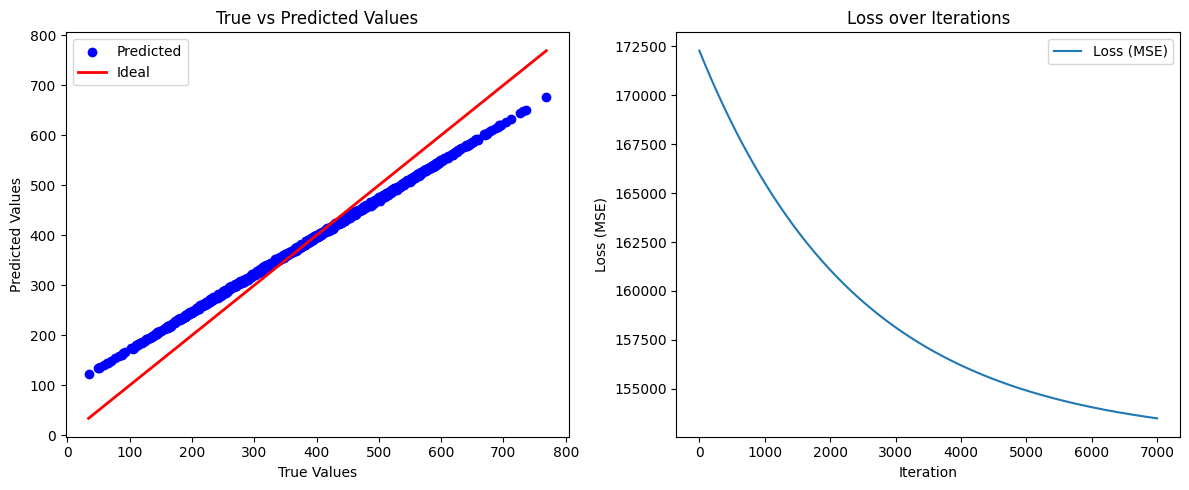

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#Caution!! SK learn is only used for performance metrics not for training and predicting
#Custom methods are implemented for training and predicting
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class ElasticNetModel:
    def __init__(self, alpha=1.0, l1_ratio=0.5, max_iter=7000, tol=1e-4):
        self.alpha = alpha  # Regularization strength
        self.l1_ratio = l1_ratio  # Ratio between L1 and L2 penalties
        self.max_iter = max_iter  # Maximum number of iterations for optimization
        self.tol = tol  # Tolerance for stopping criteria
        self.coef_ = None  # Coefficients of the model
        self.intercept_ = None  # Intercept of the model
        self.loss_history = []  # List to store loss values over iterations

    def fit(self, X, y):
        # Normalize features
        feature_mean = np.mean(X, axis=0)
        feature_std = np.std(X, axis=0)
        X_normalized = (X - feature_mean) / feature_std

        # Normalize target variable
        target_mean = np.mean(y)
        y_normalized = y - target_mean

        # Initialize coefficients and intercept
        num_samples, num_features = X_normalized.shape
        self.coef_ = np.zeros(num_features)
        self.intercept_ = target_mean

        # Gradient descent optimization loop
        for iteration in range(self.max_iter):
            y_predicted = X_normalized.dot(self.coef_) + self.intercept_

            # Compute gradient for coefficients
            gradient = -2 * X_normalized.T.dot(y_normalized - y_predicted) / num_samples
            l1_regularization = self.alpha * self.l1_ratio * np.sign(self.coef_)
            l2_regularization = self.alpha * (1 - self.l1_ratio) * self.coef_

            # Update coefficients
            new_coef = self.coef_ - self.tol * (gradient + l1_regularization + l2_regularization)

            # Calculate mean squared error for loss tracking
            loss = mean_squared_error(y_normalized, y_predicted)
            self.loss_history.append(loss)

            # Check for convergence
            if np.max(np.abs(new_coef - self.coef_)) < self.tol:
                print(f"Converged after {iteration} iterations.")
                break
            self.coef_ = new_coef

        return ElasticNetModelResults(self.coef_, self.intercept_, feature_mean, feature_std)

class ElasticNetModelResults:
    def __init__(self, coefficients, intercept, feature_mean, feature_std):
        self.coef_ = coefficients
        self.intercept_ = intercept
        self.feature_mean = feature_mean
        self.feature_std = feature_std

    def predict(self, X):
        X_normalized = (X - self.feature_mean) / self.feature_std
        return X_normalized.dot(self.coef_) + self.intercept_

def load_data(filepath):
    """Load the dataset from a CSV file."""
    data = pd.read_csv(filepath)
    X = data.iloc[:, :-1].values  # Features
    y = data.iloc[:, -1].values    # Target variable
    return X, y

def evaluate_model(model_results, X, y_true):
    """Evaluate the model's performance."""
    y_predicted = model_results.predict(X)
    mse = mean_squared_error(y_true, y_predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_predicted)
    r2 = r2_score(y_true, y_predicted)
    return mae, mse, rmse, r2, y_predicted

def plot_results(y_true, y_predicted, loss_history):
    """Visualize the model's predictions and loss over iterations."""
    plt.figure(figsize=(12, 5))

    # Plot true vs predicted values
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_predicted, color="blue", label="Predicted")
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color="red", lw=2, label="Ideal")
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title("True vs Predicted Values")
    plt.legend()

    # Plot loss over iterations
    plt.subplot(1, 2, 2)
    plt.plot(loss_history, label="Loss (MSE)")
    plt.xlabel("Iteration")
    plt.ylabel("Loss (MSE)")
    plt.title("Loss over Iterations")
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Load the dataset from a CSV file
    X, y = load_data("../tests/output.csv")
    
    # Initialize the ElasticNet model with specified parameters
    model = ElasticNetModel(alpha=0.1, l1_ratio=0.5)
    
    # Fit the model to the data
    model_results = model.fit(X, y)
    
    # Evaluate the model's performance
    mae, mse, rmse, r2, y_predicted = evaluate_model(model_results, X, y)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f}")
    
    # Display sample predictions
    print("\nSample Predictions:")
    for i in range(5):
        print(f"True Value: {y[i]:.3f}, Predicted Value: {y_predicted[i]:.3f}")
    
    # Visualize the results
    plot_results(y, y_predicted, model.loss_history)
